In [2]:
import os
from pathlib import Path

# input_directory = Path("/home/kdemyokhin_1/concept-tree-course-work/articles_triples_cleaned/arxiv-txt-cs")
input_directory = Path("/home/simon/Desktop/concept-tree/concept-tree/process_graph/articles_triples_cleaned/arxiv-txt-cs")

# Получаем список всех txt файлов рекурсивно (включая поддиректории)
input_files = list(input_directory.rglob("*.txt"))

# PICKLED_GRAPHS = "/home/kdemyokhin_1/concept-tree-course-work/pickled_graphs/"
PICKLED_GRAPHS = "/home/simon/Desktop/concept-tree/concept-tree/process_graph/pickled_graphs/"

In [1]:
from directed_graph.graph import Graph

graph = Graph()

## Построение графа из триплетов

In [3]:
# import csv
# import random

# added_edges = set()

# for path in random.sample(input_files, 10):
#     with open(path, newline='') as csvfile:
#         triplets_reader = csv.reader(csvfile, delimiter=";")
#         for triplet in triplets_reader:
#             agent_1, action, agent_2 = triplet
#             edge = (
#                 agent_1,
#                 agent_2,
#                 action,
#             )
#             if len(agent_1) == 0 or len(agent_2) == 0 or len(action) == 0:
#                 continue

#             if edge not in added_edges:
#                 added_edges.add(edge)
#                 if edge[0] not in graph.vertices:
#                     graph.add_vertex(edge[0])
#                 if edge[1] not in graph.vertices:
#                     graph.add_vertex(edge[1])
#                 graph.add_edge(*edge)

### Сохранение дампа графа:

In [4]:
# from directed_graph.graph import save_graph

# save_graph(graph, PICKLED_GRAPHS+"raw_graph.pickle")

### Подгружаем построенный сырой граф:

In [3]:
del graph

In [4]:
from directed_graph.graph import load_graph

graph = load_graph(PICKLED_GRAPHS+"raw_graph.pickle")

In [5]:
from process_graph.edges_clustering import extract_unique_sorted_embeddings

unique_edges_labels, unique_edges_embeddings = extract_unique_sorted_embeddings(graph.edges)

In [6]:
len(unique_edges_labels)

1352

In [7]:
print(unique_edges_labels)

['a', 'about', 'absorb', 'accelerate', 'accelerated of', 'accept', 'accept to', 'access', 'access for', 'access in', 'access through', 'accessed', 'accessed via', 'account for', 'achieve', 'achieve in', 'achieve of', 'achieve on', 'achieve to', 'achieved', 'achieved across', 'achieved at', 'achieved in', 'achieved of', 'achieved on', 'achieved to', 'achieved with', 'achieves', 'achieves across', 'achieves for', 'achieves of', 'achieves over', 'achieves than', 'achieves to', 'achieving', 'acknowledge', 'acknowledge of', 'across', 'act a', 'act on', 'acting a', 'adapt to', 'adapts to', 'add', 'add during', 'add of', 'address', 'address of', 'adhere to', 'adjust', 'adjust a', 'adjust from', 'adjust of', 'adopt', 'adopt due', 'adopt for', 'adopt of', 'adopted', 'adopted for', 'adopted of', 'affect', 'affect in', 'affect to', 'after', 'against', 'aggregate', 'aggregate from', 'aggregate of', 'aggregate to', 'aid in', 'aim a', 'align of', 'align to', 'align with', 'aligns with', 'allow from'

## Перебор параметров для кластеризации ребер

### Получение верхней оценки на eps в переборе

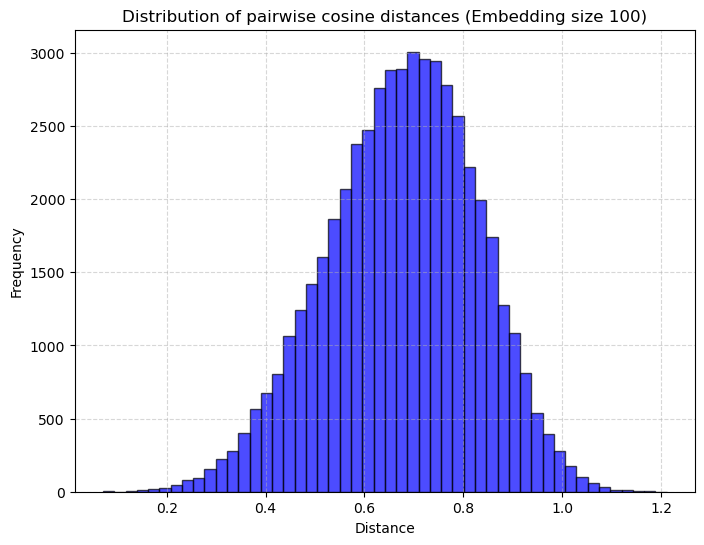

Embedding size 100: Median cosine distance = 0.6827, 90th percentile = 0.8647


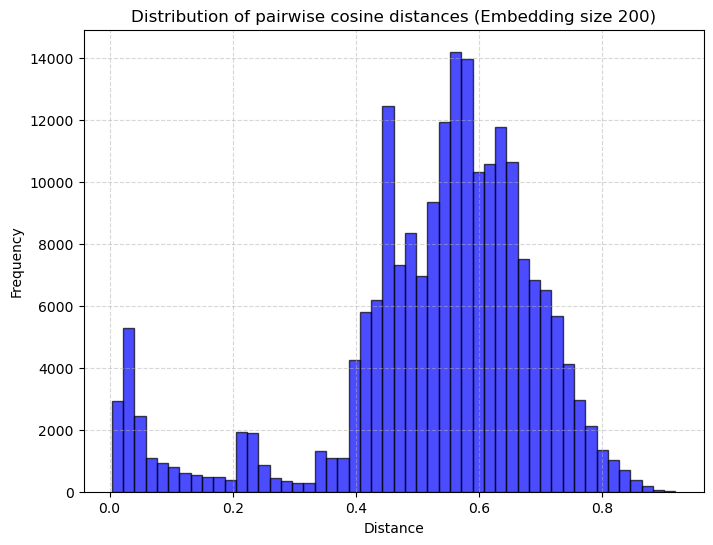

Embedding size 200: Median cosine distance = 0.5609, 90th percentile = 0.7105


{100: {'median_distance': np.float32(0.6826898),
  'percentile_90': np.float32(0.8647454)},
 200: {'median_distance': np.float32(0.5608824),
  'percentile_90': np.float32(0.7104639)}}

In [11]:
from process_graph.edges_clustering import analyze_distance_distributions

analyze_distance_distributions(verbs_embeddings, metric="cosine")

In [12]:
# analyze_distance_distributions(unique_edges_embeddings, metric="euclidean")

In [13]:
from collections import defaultdict

# Инициализация словаря для хранения количества рёбер по размеру эмбеддингов
edges_count_by_size = defaultdict(int)

# Подсчёт количества рёбер для каждого размера эмбеддингов
for edge_emb in verbs_embeddings:
    embedding_size = len(edge_emb)
    edges_count_by_size[embedding_size] += 1

# Вывод результатов
for size, count in edges_count_by_size.items():
    print(f"Размер эмбеддинга: {size}, Количество уникальных рёбер: {count}")

Размер эмбеддинга: 100, Количество уникальных рёбер: 320
Размер эмбеддинга: 200, Количество уникальных рёбер: 647


In [11]:
from process_graph.edges_clustering import (
    grid_search_cluster_params,
    compute_connectivity_matrix,
)
import numpy as np

model_param_grid = {
    "DBSCAN": {
        "eps": np.linspace(0.2, 1, 20),
        "min_samples": np.linspace(10, 100, 20, dtype=np.int64),
        "metric": ["cosine"],
    },
    "AgglomerativeClustering": {
        "n_clusters": np.linspace(10, 40, 20, dtype=np.int64),
        "metric": ["cosine", "euclidean"],
        "linkage": ["ward", "complete", "average", "single"],
        "connectivity": [
            None,
            compute_connectivity_matrix(graph.edges, [100, 200, 300], "adjacency"),
            # compute_connectivity_matrix(graph.edges, [100, 200, 300], "shortest_path"),
        ],
    },
}
embedding_sizes = [100, 200]

In [14]:
    # Поиск оптимальных параметров
best_params, best_scores = grid_search_cluster_params(unique_edges_embeddings, embedding_sizes, model_param_grid, standardize=False)

Embedding size 100, model=DBSCAN, params={'eps': np.float64(0.2), 'min_samples': np.int64(10), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(0.2), 'min_samples': np.int64(14), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(0.2), 'min_samples': np.int64(19), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(0.2), 'min_samples': np.int64(24), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(0.2), 'min_samples': np.int64(28), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 100, model=DBSCAN, params={'eps': np.float64(0.2), 'min_samples': np.int64(33), 'metric': 'cosine'}: Skipping due to infinite or undefined m

/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 23 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklea

Embedding size 100: Best model = AgglomerativeClustering, Best params = {'n_clusters': np.int64(10), 'metric': 'euclidean', 'linkage': 'complete'}
Best Metrics:
  Silhouette Score: 0.5402153134346008
  Davies-Bouldin Index: 0.582621796791693
  Calinski-Harabasz Index: 25.200244903564453
  Dunn Index: 0.6155350208282471
  Connectivity Score: 0.02289156626506024
  Intra-Cluster Variance: 0.1851477175951004
Embedding size 200, model=DBSCAN, params={'eps': np.float64(0.3263157894736842), 'min_samples': np.int64(90), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 200, model=DBSCAN, params={'eps': np.float64(0.3263157894736842), 'min_samples': np.int64(95), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 200, model=DBSCAN, params={'eps': np.float64(0.3263157894736842), 'min_samples': np.int64(100), 'metric': 'cosine'}: Skipping due to infinite or undefined metric values.
Embedding size 200, model=DBSCAN, param

/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

cosine was provided as metric. Ward can only work with euclidean distances.
cosine was provided as metric. Ward can only work with euclidean distances.


/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:596: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/home/simon/miniconda3/envs/venv_02_pipeline/lib/python3.12/site-packages/sk

Embedding size 200: Best model = DBSCAN, Best params = {'eps': np.float64(0.28421052631578947), 'min_samples': np.int64(24), 'metric': 'cosine'}
Best Metrics:
  Silhouette Score: 0.49344488978385925
  Davies-Bouldin Index: 1.8361794610177355
  Calinski-Harabasz Index: 334.34161376953125
  Dunn Index: 0.4678513705730438
  Connectivity Score: 0.05819672131147541
  Intra-Cluster Variance: 0.6626855134963989


In [17]:
best_params

{100: {'model': 'AgglomerativeClustering',
  'params': {'n_clusters': np.int64(10),
   'metric': 'euclidean',
   'linkage': 'complete'}},
 200: {'model': 'DBSCAN',
  'params': {'eps': np.float64(0.28421052631578947),
   'min_samples': np.int64(24),
   'metric': 'cosine'}}}

In [18]:
best_scores

{100: {'Silhouette Score': np.float32(0.5402153),
  'Davies-Bouldin Index': np.float64(0.582621796791693),
  'Calinski-Harabasz Index': np.float32(25.200245),
  'Dunn Index': np.float32(0.615535),
  'Connectivity Score': 0.02289156626506024,
  'Intra-Cluster Variance': np.float32(0.18514772)},
 200: {'Silhouette Score': np.float32(0.4934449),
  'Davies-Bouldin Index': np.float64(1.8361794610177355),
  'Calinski-Harabasz Index': np.float32(334.3416),
  'Dunn Index': np.float32(0.46785137),
  'Connectivity Score': 0.05819672131147541,
  'Intra-Cluster Variance': np.float32(0.6626855)}}

In [19]:
from process_graph.edges_clustering import cluster_and_evaluate_all_sizes
metrics, edge_label_map = cluster_and_evaluate_all_sizes(unique_edges_embeddings, unique_edges_labels, best_params, standardize=False)

In [20]:
edge_label_map

{100: {np.str_('at'): np.str_('in'),
  np.str_('in'): np.str_('in'),
  np.str_('on'): np.str_('in'),
  np.str_('about'): np.str_('incorporate'),
  np.str_('absorb'): np.str_('incorporate'),
  np.str_('accelerate'): np.str_('incorporate'),
  np.str_('accept'): np.str_('incorporate'),
  np.str_('access'): np.str_('incorporate'),
  np.str_('accessed'): np.str_('incorporate'),
  np.str_('achieve'): np.str_('incorporate'),
  np.str_('achieved'): np.str_('incorporate'),
  np.str_('achieves'): np.str_('incorporate'),
  np.str_('achieving'): np.str_('incorporate'),
  np.str_('acknowledge'): np.str_('incorporate'),
  np.str_('across'): np.str_('incorporate'),
  np.str_('add'): np.str_('incorporate'),
  np.str_('address'): np.str_('incorporate'),
  np.str_('adjust'): np.str_('incorporate'),
  np.str_('adopt'): np.str_('incorporate'),
  np.str_('adopted'): np.str_('incorporate'),
  np.str_('affect'): np.str_('incorporate'),
  np.str_('after'): np.str_('incorporate'),
  np.str_('against'): np.str_

In [21]:
cluster_to_words = {}
for emb_size in edge_label_map:
    cluster_to_words[emb_size] = {}
    for label1, label2 in edge_label_map[emb_size].items():
        if label2 not in cluster_to_words[emb_size]:
            cluster_to_words[emb_size][label2] = []
        cluster_to_words[emb_size][label2].append(label1)

In [22]:
cluster_to_words

{100: {np.str_('in'): [np.str_('at'), np.str_('in'), np.str_('on')],
  np.str_('incorporate'): [np.str_('about'),
   np.str_('absorb'),
   np.str_('accelerate'),
   np.str_('accept'),
   np.str_('access'),
   np.str_('accessed'),
   np.str_('achieve'),
   np.str_('achieved'),
   np.str_('achieves'),
   np.str_('achieving'),
   np.str_('acknowledge'),
   np.str_('across'),
   np.str_('add'),
   np.str_('address'),
   np.str_('adjust'),
   np.str_('adopt'),
   np.str_('adopted'),
   np.str_('affect'),
   np.str_('after'),
   np.str_('against'),
   np.str_('aggregate'),
   np.str_('along'),
   np.str_('alongside'),
   np.str_('among'),
   np.str_('amplifies'),
   np.str_('analyze'),
   np.str_('analyzed'),
   np.str_('analyzes'),
   np.str_('answer'),
   np.str_('answering'),
   np.str_('append'),
   np.str_('applies'),
   np.str_('apply'),
   np.str_('approach'),
   np.str_('around'),
   np.str_('arrives'),
   np.str_('assess'),
   np.str_('assesses'),
   np.str_('assigns'),
   np.str_('

In [23]:
clusters_amount = {}
for emb_size in cluster_to_words:
    clusters_amount[emb_size]=len(cluster_to_words[emb_size])

In [24]:
clusters_amount

{100: 10, 200: 168}

In [25]:
unique_labels = set()
for edge in graph.edges:
    unique_labels.add(edge.label)

In [26]:
len(unique_labels)

1352

In [15]:
from process_graph.edges_clustering import plot_clusters_with_pca

plot_clusters_with_pca(unique_edges_embeddings, unique_edges_labels, edge_label_map)

In [28]:
edge_label_map

{100: {np.str_('at'): np.str_('in'),
  np.str_('in'): np.str_('in'),
  np.str_('on'): np.str_('in'),
  np.str_('about'): np.str_('incorporate'),
  np.str_('absorb'): np.str_('incorporate'),
  np.str_('accelerate'): np.str_('incorporate'),
  np.str_('accept'): np.str_('incorporate'),
  np.str_('access'): np.str_('incorporate'),
  np.str_('accessed'): np.str_('incorporate'),
  np.str_('achieve'): np.str_('incorporate'),
  np.str_('achieved'): np.str_('incorporate'),
  np.str_('achieves'): np.str_('incorporate'),
  np.str_('achieving'): np.str_('incorporate'),
  np.str_('acknowledge'): np.str_('incorporate'),
  np.str_('across'): np.str_('incorporate'),
  np.str_('add'): np.str_('incorporate'),
  np.str_('address'): np.str_('incorporate'),
  np.str_('adjust'): np.str_('incorporate'),
  np.str_('adopt'): np.str_('incorporate'),
  np.str_('adopted'): np.str_('incorporate'),
  np.str_('affect'): np.str_('incorporate'),
  np.str_('after'): np.str_('incorporate'),
  np.str_('against'): np.str_

In [30]:
import pickle

with open(PICKLED_GRAPHS+'edges_clustered_label_dict.pickle', 'wb') as handle:
    pickle.dump(edge_label_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
import pickle

with open(PICKLED_GRAPHS+'edges_clustered_label_dict.pickle', 'rb') as handle:
    edge_label_map = pickle.load(handle)

In [ ]:
"""
Cluster vertices
"""

from process_graph.squeezing import squeeze

(
    (words_to_cluster, merged_words_map),
    (bigrams_to_cluster, merged_bigrams_map),
    (trigrams_to_cluster, merged_trigrams_map),
) = squeeze((0.4, 0.1, 0.1), graph.vertices.values())

operands could not be broadcast together with shapes (1800,) (900,) : [[[formula th aggregated network layer]]]; whose parameter matrix
operands could not be broadcast together with shapes (1800,) (900,) : [[[formula th large model]]]; whose parameter matrix
operands could not be broadcast together with shapes (2700,) (900,) : [[[formula th layer]]]; whose parameter matrix


In [ ]:
"""
Cluster edges
"""
from process_graph.edges_clustering import cluster_and_evaluate_all_sizes

edge_map, metrics = cluster_and_evaluate_all_sizes(graph.edges, with_metrics=True)

In [ ]:
metrics

{'embedding_size_300': {'Silhouette Score': np.float32(0.4935592),
  'Davies-Bouldin Index': np.float64(1.4662594633483381),
  'Calinski-Harabasz Index': np.float32(49.34576)},
 'embedding_size_600': {'Silhouette Score': np.float32(0.20228788),
  'Davies-Bouldin Index': np.float64(1.5148926834137941),
  'Calinski-Harabasz Index': np.float32(7.719379)}}

In [ ]:
clustered_graph = Graph()

for new_vertice_words in merged_words_map.keys():
    clustered_graph.add_vertex(new_vertice_words, new_vertice_words.split()[:3])
for new_vertice_bigram in merged_bigrams_map.keys():
    clustered_graph.add_vertex(new_vertice_bigram, new_vertice_bigram.split()[:3])
for new_vertice_trigram in merged_trigrams_map.keys():
    clustered_graph.add_vertex(new_vertice_trigram, new_vertice_trigram.split()[:3])

def match_new_vertice(label: str) -> str:
    new_label = str()
    if label in words_to_cluster:
        new_label = words_to_cluster[label]
    elif label in bigrams_to_cluster:
        new_label = bigrams_to_cluster[label]
    elif label in trigrams_to_cluster:
        new_label = trigrams_to_cluster[label]
    return new_label

added_edges = set()  # keeps added_edges in (agent_1, agent_2, label) format

for edge in tqdm.tqdm(graph.edges):
    new_edge = (
        match_new_vertice(edge.agent_1),
        match_new_vertice(edge.agent_2),
        edge_map[edge.label] if edge.label in edge_map else edge.label,
    )
    if new_edge in added_edges:
        continue

    clustered_graph.add_edge(*new_edge)

100%|██████████| 1307/1307 [00:00<00:00, 1377.95it/s]


In [ ]:
print(graph)

print(clustered_graph)

Graph(
	vertices=[Vertex(concept='mobile device', words=['mobile', 'device']), Vertex(concept='shared global model', words=['shared', 'global', 'model']), Vertex(concept='client', words=['client']), Vertex(concept='client private data', words=['client', 'private', 'data']), Vertex(concept='server', words=['server']), Vertex(concept='model aggregation', words=['model', 'aggregation']), Vertex(concept='heterogeneous client', words=['heterogeneous', 'client']), Vertex(concept='federated client', words=['federated', 'client']), Vertex(concept='diverse system resource', words=['diverse', 'system', 'resource']), Vertex(concept='heterogeneous model', words=['heterogeneous', 'model']), Vertex(concept='data distribution', words=['data', 'distribution']), Vertex(concept='high end pc', words=['high', 'end', 'pc']), Vertex(concept='large model', words=['large', 'model']), Vertex(concept='sub model', words=['sub', 'model']), Vertex(concept='previous solution', words=['previous', 'solution']), Verte

In [ ]:
from directed_graph.visualize_graph import visualize_graph_ngrams, visualize_graph_ngrams_with_pca
# visualize_graph_ngrams(clustered_graph)
visualize_graph_ngrams_with_pca(clustered_graph)

Excluded vertices due to inconsistent embedding dimensions: {'[[[formula th aggregated network layer]]]', '[[[formula th large model]]]', '[[[formula th layer]]]'}


In [ ]:
from collections import defaultdict

edge_cluster_to_word_map = defaultdict(list)
for key, value in edge_map.items():
    edge_cluster_to_word_map[value].append(key)
edge_cluster_to_word_map = dict(edge_cluster_to_word_map)


In [ ]:
import json

def print_beautiful_dict(d):
    """Prints a dictionary with pretty formatting."""
    print(json.dumps(d, indent=4, sort_keys=True))

print_beautiful_dict(edge_cluster_to_word_map)

{
    "address": [
        "address"
    ],
    "aggregates": [
        "aggregates"
    ],
    "among": [
        "among"
    ],
    "applies": [
        "apply",
        "applies"
    ],
    "as": [
        "as"
    ],
    "between": [
        "between"
    ],
    "broadcasts": [
        "broadcasts"
    ],
    "captures": [
        "distills",
        "captures",
        "capture"
    ],
    "carry": [
        "carry"
    ],
    "compress": [
        "compress"
    ],
    "conduct": [
        "conduct"
    ],
    "contain via": [
        "compress via",
        "generate via",
        "optimize via",
        "contain via"
    ],
    "decreases below": [
        "decreases below",
        "remains above"
    ],
    "demonstrate of": [
        "have for",
        "distills from",
        "imposes on",
        "train on",
        "distribute of",
        "suffer from",
        "retain of",
        "performs on",
        "assigns to",
        "incur for",
        "formulate as",
       

In [ ]:
len(edge_cluster_to_word_map.keys())

48

In [ ]:
len(edge_cluster_to_word_map.keys())

In [ ]:
from directed_graph.graph import save_graph

save_graph(clustered_graph, "clustered_graph.pickle")